# LENS analysis

an example for a LENS analysis as in the [original paper](https://doi.org/10.48550/arXiv.2212.12694)

extra requirements:
```
matplotlib
sklearn
scipy
seaborn
```

In [1]:
import SOAPify.HDF5er as HDF5er
import SOAPify
import h5py
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from multiprocessing.pool import ThreadPool as Pool
from seaborn import kdeplot

cutoff = 2.88 * 1.1


## Load data

Let's get the data:
```bash
wget https://github.com/GMPavanLab/dynNP/releases/download/V1.0-trajectories/ico309.hdf5
```
We'll start by caclulating the neighbours and the LENS parameters

using cutoff=2.88*1.1 that is 10% more than the Au radius

In [2]:
wantedTrajectory = slice(0, None, 10)
with h5py.File("ico309.hdf5", "r") as trajFile:
    tgroup = trajFile["/Trajectories/ico309-SV_18631-SL_31922-T_500"]
    universe = HDF5er.createUniverseFromSlice(tgroup, wantedTrajectory)


In [3]:
neigCounts = SOAPify.analysis.listNeighboursAlongTrajectory(universe, cutOff=cutoff)
LENS, nn, *_ = SOAPify.analysis.neighbourChangeInTime(neigCounts)

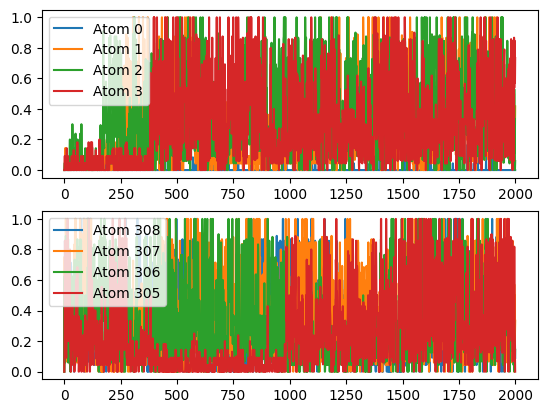

In [4]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(LENS[i], label=f"Atom {i}")
    axes[1].plot(LENS[308 - i], label=f"Atom {308-i}")

for ax in axes:
    ax.legend()

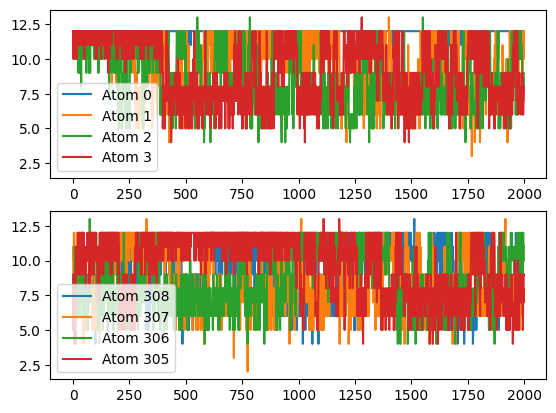

In [5]:
fig, axes = plt.subplots(2, sharey=True)
for i in range(4):
    axes[0].plot(nn[i], label=f"Atom {i}")
    axes[1].plot(nn[308 - i], label=f"Atom {308-i}")

for ax in axes:
    ax.legend()

## Filtering

Let's chose an atom  try to apply a filter on it:

(2000,)


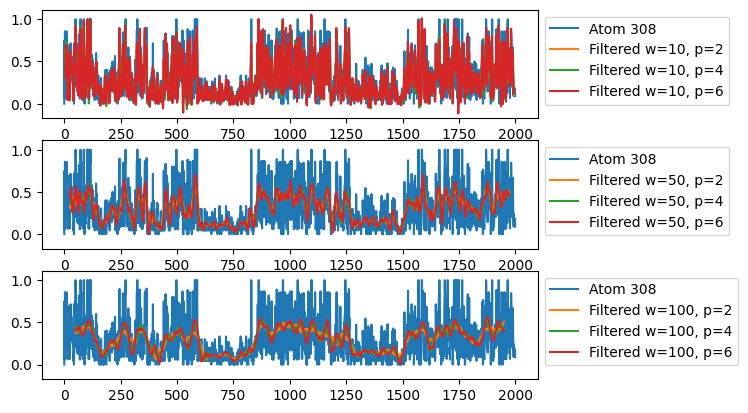

In [6]:
atom = 308
savGolPrint = np.arange(LENS[atom].shape[0])
windows = [10, 50, 100]
polyorders = [2, 4, 6]
fig, axes = plt.subplots(len(windows), sharey=True)

for ax, window_length in zip(axes, windows):
    windowToPlot = slice(window_length // 2, -window_length // 2)
    ax.plot(LENS[atom], label=f"Atom {atom}")
    for polyorder in polyorders:
        savgol = savgol_filter(
            LENS[atom], window_length=window_length, polyorder=polyorder
        )
        ax.plot(
            savGolPrint[windowToPlot],
            savgol[windowToPlot],
            label=f"Filtered w={window_length}, p={polyorder}",
        )
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
print(savgol.shape)

Like in the paper we will chose `window_length=100` and `polyorder=2`
ad apply the filter to all of the LENS trajectories

In [7]:
window_length = 100
polyorder = 2
windowToUSE = slice(window_length // 2, -window_length // 2)
filteredLENS = np.empty_like(LENS)
for i, at in enumerate(LENS):
    filteredLENS[i] = savgol_filter(
        at, window_length=window_length, polyorder=polyorder
    )

We proceed with the clustering: we try to group the frames by their values using KMeans

`silhouette_score` is O(n^2), so we need a way to reduce its time

In [9]:
def transposeAndFlatten(x, /):
    trans = np.transpose(x)
    trans_fl = np.reshape(trans, np.shape(trans)[0] * np.shape(trans)[1])
    return trans_fl


dataToFit = transposeAndFlatten(filteredLENS[:, windowToUSE])
print("minmax: ", np.min(dataToFit), np.max(dataToFit))

minmax:  -0.018211861305947333 0.6840905246350124


In [ ]:
scores = np.zeros(10)
rng = np.random.default_rng(12345)
indexes = rng.integers(0, dataToFit.shape[0], int(np.sqrt(dataToFit.shape[0])))

#This may not work well on Jupyter notebooks, i have a ~10% rate of success

def calculateScores(nclusters):
    clusters = KMeans(nclusters).fit_predict(dataToFit.reshape(-1, 1))
    score = silhouette_score(dataToFit[indexes].reshape(-1, 1), clusters[indexes])
    # print (nclusters, score)
    return score


with Pool(10) as p:
    scores = p.map(calculateScores, list(range(2, 12)))


fig, ax = plt.subplots(1, figsize=(5, 5), dpi=200)
_ = ax.plot(range(2, 12), scores)

`bestnclusters` should be 2 in our case, but we still go with 4.

We store some of the informations from the clusters, we then proceed with some visualizations to understand if the number of cluster is ok

In [10]:
bestnclusters = 4
clusters = KMeans(bestnclusters).fit_predict(dataToFit.reshape(-1, 1))
data_KM = {}
for i in range(bestnclusters):
    data_KM[i] = {}
    data_KM[i]["elements"] = dataToFit[clusters == i]
    data_KM[i]["min"] = np.min(data_KM[i]["elements"])
    data_KM[i]["max"] = np.max(data_KM[i]["elements"])


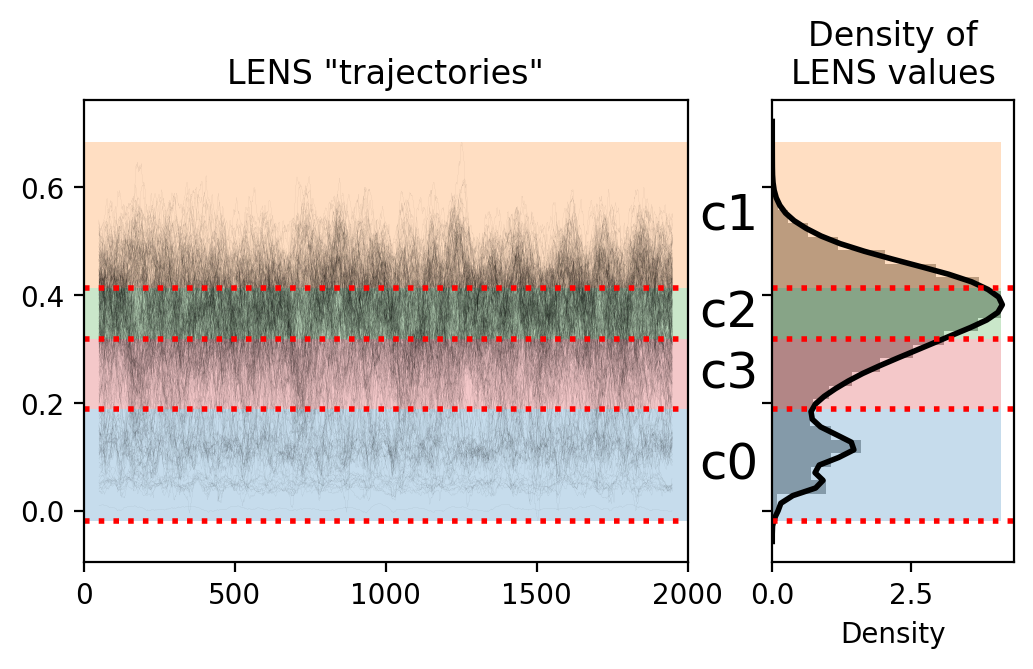

In [11]:
fig, axes = plt.subplots(
    1, 2, figsize=(6, 3), dpi=200, width_ratios=[3, 1.2], sharey=True
)

for flns in filteredLENS:
    axes[0].plot(
        savGolPrint[windowToUSE],
        flns[windowToUSE],
        color="k",
        linewidth=0.01,
        # alpha=0.9,
    )
hist = axes[1].hist(
    dataToFit,
    alpha=0.7,
    color="gray",
    bins="doane",
    density=True,
    orientation="horizontal",
)
kde = kdeplot(
    y=dataToFit,
    bw_adjust=1.5,
    linewidth=2,
    color="black",
    # gridsize=500,
    gridsize=2 * (hist[1].shape[0] - 1),
    ax=axes[1],
)
axes[0].set_title('LENS "trajectories"')
axes[0].set_xlim(0, len(savGolPrint))
axes[1].set_title("Density of\nLENS values")
height = np.max(hist[0])
for cname, data in data_KM.items():
    # center = delta+data['min']
    bin_size = data["max"] - data["min"]
    for i, ax in enumerate(axes):
        ax.barh(
            y=data["min"],
            width=len(savGolPrint) if i == 0 else height,
            height=bin_size,
            align="edge",
            alpha=0.25,
            # color=colors[idx_m],
            linewidth=2,
        )
        ax.axhline(y=data["min"], c="red", linewidth=2, linestyle=":")
        if i == 1:
            ax.text(
                -0.25,
                data["min"] + bin_size / 2.0,
                f"c{cname}",
                va="center",
                ha="right",
                fontsize=18,
            )


The idea is to play with the clustering until you are satisfied, then to visualize and try to give an interpretation (and then change agani the method of clustering until you are satisfied):

## Visualization: ovito-compatible

Let's define some helper functions and then export the data in a xyz that is compatible with ovito

In [16]:
def prepareData(x, /):
    """prepares an array from shape (atom,frames) to  (frames,atom)"""
    shape = x.shape
    toret = np.empty((shape[1], shape[0]), dtype=x.dtype)
    for i, atomvalues in enumerate(x):
        toret[:, i] = atomvalues
    return toret


# classyfing by knoing the min/max of the clusters
def classifying(x, classDict):
    toret = np.ones_like(x, dtype=int) * (len(classDict) - 1)
    # todo: sort  by max and then classify
    minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
    minmax = sorted(minmax, key=lambda x: -x[1])
    #print(minmax)
    for cname, myMax in minmax:
        toret[x < myMax] = int(cname)
    return toret


# classifying(filteredLENS,data_KM)
classifiedFilteredLENS = classifying(filteredLENS, data_KM)


In [13]:
with h5py.File("ico309.hdf5", "r") as trajFile, open(
    "outClassified.xyz", "w"
) as xyzFile:
    tgroup = trajFile["/Trajectories/ico309-SV_18631-SL_31922-T_500"]
    HDF5er.getXYZfromTrajGroup(
        xyzFile,
        tgroup,
        framesToExport=wantedTrajectory,
        allFramesProperty='Origin="-40 -40 -40"',
        LENS=prepareData(LENS),
        filteredLENS=prepareData(filteredLENS),
        proposedClassification=prepareData(classifiedFilteredLENS),
    )


Let's visualize a few LENS trajectories colored by the cluster in time

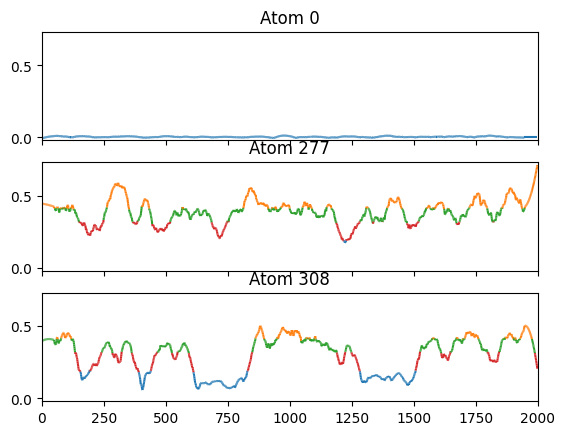

In [14]:
fig, axes = plt.subplots(3, sharey=True, sharex=True)

minmax = [[cname, data["max"]] for cname, data in data_KM.items()]
minmax = sorted(minmax, key=lambda x: x[1])
cmap = ListedColormap([f"C{m[0]}" for m in minmax])
norm = BoundaryNorm([0] + [m[1] for m in minmax], cmap.N)

for atom, ax in zip([0, 277, 308], axes):
    points = np.array([savGolPrint, filteredLENS[atom]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(filteredLENS[atom])

    line = ax.add_collection(lc)
    # ax.scatter(savGolPrint,filteredLENS[atom],c=classifiedFilteredLENS[atom])
    ax.set_title(f"Atom {atom}")

axes[0].set_xlim(savGolPrint[0] - 1, savGolPrint[-1] + 1)
_ = axes[0].set_ylim(-0.02, np.max(filteredLENS) + 0.02)


## Time analysis

Let's calculate the transition matrix for this LENS analysis

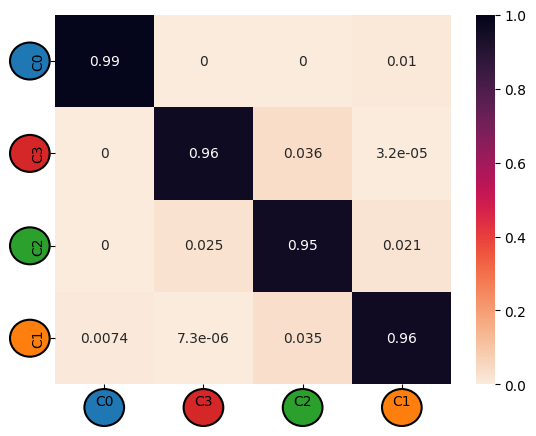

In [15]:
from SOAPify import SOAPclassification, calculateTransitionMatrix, normalizeMatrixByRow
from seaborn import heatmap

classifications = SOAPclassification(
    [], prepareData(classifiedFilteredLENS), [f"C{m[0]}" for m in minmax]
)
tmat = calculateTransitionMatrix(classifications)
tmat = normalizeMatrixByRow(tmat)
_, ax = plt.subplots(1)
heatmap(
    tmat,
    vmax=1,
    vmin=0,
    cmap="rocket_r",
    annot=True,
    xticklabels=classifications.legend,
    yticklabels=classifications.legend,
    ax=ax,
)

for i, label in enumerate(classifications.legend):
    ax.add_patch(
        Circle(
            (0.5 + i, len(classifications.legend) + 0.25),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
    ax.add_patch(
        Circle(
            (-0.25, 0.5 + i),
            facecolor=label,
            lw=1.5,
            edgecolor="black",
            radius=0.2,
            clip_on=False,
        )
    )
